# Pandora metrics

Purpose of this notebook is to introduce the definition of some important metrics, and produce the corresponding reference peformance results achieved by Pandora [Eur. Phys. J. C 78, 82 (2018), https://arxiv.org/abs/1708.03135], the reconstruction toolkit used in many MicroBooNE publications.

Get libraries, utils, and data

In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
from standard_labels import *
from file_utils import *
from detector_utils import *

In [3]:
f = h5py.File("NeutrinoML_Open_NoWire_bnb-test.h5", "r")
#f = h5py.File("NeutrinoML_Open_NoWire_nue-test.h5", "r")

## Slice Neutrino Purity

Convert hit, pandoraHit, and edep tables into data frames. The pandoraHit table contains information about how pandora clustered those hits. The edep table contains the truth information about the hits. Merge the data frames based on the hit_id and the edep with largest contribution to the hit in terms for energy fraction.

In [4]:
hits = Table2DataFrame(f["hit_table"])

pandhits = Table2DataFrame(f["pandoraHit_table"])
hits = hits.merge(pandhits, on=["run","sub","evt","hit_id"])

edeps = Table2DataFrame(f["edep_table"])
edeps = edeps.sort_values(by=['energy_fraction'], ascending=False, kind='mergesort').drop_duplicates(["run","sub","evt","hit_id"])
hits = hits.merge(edeps, on=["run","sub","evt","hit_id"], how="left")
hits['g4_id'] = hits['g4_id'].fillna(-1)
hits = hits.fillna(0)

hits


,run,sub,evt,hit_id,integral,local_plane,local_time,local_wire,rms,tpc,pfp_id,slice_id,energy,energy_fraction,g4_id
0,7419,0,1,0,31.001060,0,368.940857,0,2.765357,0,-1,5,0.0,0.0,-1.0
1,7419,0,1,1,29.861094,0,1454.587402,0,2.674901,0,-1,5,0.0,0.0,-1.0
2,7419,0,1,2,86.232323,0,2416.763184,0,5.333233,0,-1,5,0.0,0.0,-1.0
3,7419,0,1,3,23.252098,0,4613.027832,0,3.065675,0,-1,5,0.0,0.0,-1.0
4,7419,0,1,4,46.391190,0,5387.874023,18,3.545477,0,-1,3,0.0,0.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12456527,7633,266,13321,12831,127.240005,2,4426.600098,3418,2.935537,0,-1,10,0.0,0.0,-1.0
12456528,7633,266,13321,12832,34.886086,2,1313.287598,3422,3.231390,0,-1,12,0.0,0.0,-1.0
12456529,7633,266,13321,12833,34.118492,2,4390.883301,3427,3.108485,0,-1,10,0.0,0.0,-1.0
12456530,7633,266,13321,12834,39.177521,2,343.569244,3441,3.387861,0,-1,20,0.0,0.0,-1.0


Pandora separates hits into "slices", where each slice is meant to collect hits from a different interaction (whether from neutrino or cosmic rays). Identifying the neutrino interaction slice is a fundamental step for the reconstruction of the neutrino interaction.

We first extract the hit information counting the hits in each slice for each event.

In [5]:
slicehits = hits.groupby(["run","sub","evt","slice_id"]).size().reset_index().rename(columns={0:'tothits'})
slnuhits = hits[hits['g4_id']>=0].groupby(["run","sub","evt","slice_id"]).size().reset_index().rename(columns={0:'nuhits'})

slicehits = slicehits.merge(slnuhits, on=["run","sub","evt","slice_id"], how='left')
slicehits['nuhits'] = slicehits['nuhits'].fillna(0)
slicehits

,run,sub,evt,slice_id,tothits,nuhits
0,7419,0,1,-1,1,0.0
1,7419,0,1,0,1495,8.0
2,7419,0,1,1,1499,3.0
3,7419,0,1,2,1221,0.0
4,7419,0,1,3,1198,0.0
...,...,...,...,...,...,...
17539,7633,266,13321,17,7,0.0
17540,7633,266,13321,18,7,0.0
17541,7633,266,13321,19,7,0.0
17542,7633,266,13321,20,6,0.0


We can now plot the fraction of neutrino hits (purity) in all pandora slices, including both those identified as neutrino and those identified as cosmics. Ideally we would like to have two populations, one peaking at zero (for cosmic slices) and one peaking at one (for neutrino slices).

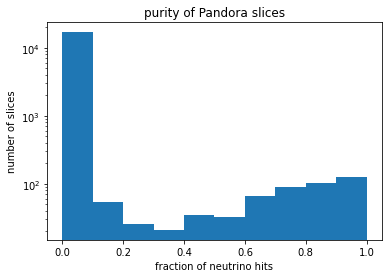

In [6]:
plt.hist(slicehits['nuhits']/slicehits['tothits'],bins=10,range=(0,1))
plt.yscale('log')
plt.xlabel('fraction of neutrino hits')
plt.ylabel('number of slices')
plt.title('purity of Pandora slices')
plt.show()

Now, in order to make a more detailed analysis of the slice properties, we need to use the "pandoraPrimary" table, which gathers information from the slice identification and high-level neutrino reconstruction. Primary here refers to the particle entering the detector and interacting with the argon. Products of this interaction would be considered "secondaries" and their info is in the "pandoraPfp_table".

In [7]:
primary = Table2DataFrame(f["pandoraPrimary_table"])
primary

,run,sub,evt,vtx_0,vtx_1,vtx_2,vtx_wire_pos_0,vtx_wire_pos_1,vtx_wire_pos_2,flashmatch_score,nu_score,pdg,slice_id,vtx_wire_time
0,7419,0,1,148.910645,112.791679,596.446350,1007,1652,1987,36.223362,-999.000000,13,0,3512.572021
1,7419,0,1,15.657176,114.753769,359.529266,606,1263,1198,126.976807,-999.000000,13,1,1085.212769
2,7419,0,1,248.027817,111.200584,142.987137,255,892,476,49.429428,-999.000000,13,2,5318.101074
3,7419,0,1,251.751404,116.713654,10.067689,18,686,33,29.871815,-999.000000,13,3,5385.930176
4,7419,0,1,130.091476,113.328796,438.976685,743,1391,1462,13.516474,-999.000000,13,4,3169.760010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24856,7633,266,13321,116.354889,-93.944382,1007.700012,2289,1741,3358,67.637939,0.030077,13,12,2919.532959
24857,7633,266,13321,-25.039635,-44.646664,1032.623047,2188,1925,3441,9999.000000,-999.000000,13,20,343.875366
24858,7633,266,13321,-8.037396,69.183601,953.634399,1728,2122,3178,66.650589,-999.000000,13,21,653.589966
24859,7633,266,13321,-999.000000,-999.000000,-999.000000,0,0,0,9999.000000,0.030077,11,12,-17397.890625


Since slices identified as cosmics may contain more than one identified cosmic interaction, if we want to study slice properties we need to identify these cases and drop the corresponding duplicate entries. By merging with the slicehits dataframe we now have access to both the slice hits and slice indentification infomation.

In [8]:
slices = primary.drop_duplicates(["run","sub","evt","slice_id"])
slices = slices.merge(slicehits, on=["run","sub","evt","slice_id"], how='left')
slices

,run,sub,evt,vtx_0,vtx_1,vtx_2,vtx_wire_pos_0,vtx_wire_pos_1,vtx_wire_pos_2,flashmatch_score,nu_score,pdg,slice_id,vtx_wire_time,tothits,nuhits
0,7419,0,1,148.910645,112.791679,596.446350,1007,1652,1987,36.223362,-999.000000,13,0,3512.572021,1495,8.0
1,7419,0,1,15.657176,114.753769,359.529266,606,1263,1198,126.976807,-999.000000,13,1,1085.212769,1499,3.0
2,7419,0,1,248.027817,111.200584,142.987137,255,892,476,49.429428,-999.000000,13,2,5318.101074,1221,0.0
3,7419,0,1,251.751404,116.713654,10.067689,18,686,33,29.871815,-999.000000,13,3,5385.930176,1198,0.0
4,7419,0,1,130.091476,113.328796,438.976685,743,1391,1462,13.516474,-999.000000,13,4,3169.760010,889,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17480,7633,266,13321,274.047974,-96.239708,843.779541,2022,1461,2812,9999.000000,-999.000000,13,18,5792.086914,7,0.0
17481,7633,266,13321,-11.439162,88.468765,931.754944,1636,2141,3105,9999.000000,-999.000000,13,19,591.622986,7,0.0
17482,7633,266,13321,-25.039635,-44.646664,1032.623047,2188,1925,3441,9999.000000,-999.000000,13,20,343.875366,6,0.0
17483,7633,266,13321,-8.037396,69.183601,953.634399,1728,2122,3178,66.650589,-999.000000,13,21,653.589966,6,0.0


We can now separate the two populations mentioned above, by selecting the slices identified as neutrino (pdg code 12 or 14, for nue and numu) from those identified as cosmics.

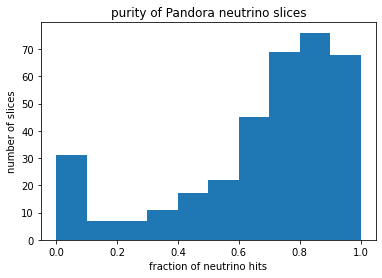

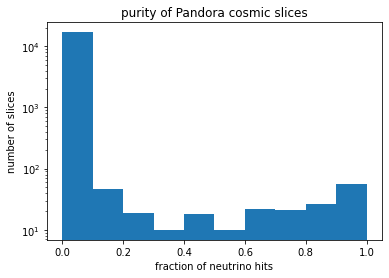

In [9]:
nuslices = slices[(slices['pdg']==12)|(slices['pdg']==14)]
plt.hist(nuslices['nuhits']/nuslices['tothits'],bins=10,range=(0,1))
plt.xlabel('fraction of neutrino hits')
plt.ylabel('number of slices')
plt.title('purity of Pandora neutrino slices')
plt.show()

cosmslices = slices[(slices['pdg']!=12)&(slices['pdg']!=14)]
plt.hist(cosmslices['nuhits']/cosmslices['tothits'],bins=10,range=(0,1))
plt.yscale('log')
plt.xlabel('fraction of neutrino hits')
plt.ylabel('number of slices')
plt.title('purity of Pandora cosmic slices')
plt.show()

## Neutrino Slice ID Efficiency and Vertex Resolution

Get the event table, where the true neutrino interaction vertex position is stored. This will compared to the quantity reconstructed by Pandora, i.e. the vertex position of the slices identified as neutrino interactions.

In [10]:
event = Table2DataFrame(f["event_table"])
event

,run,sub,evt,nu_dir_0,nu_dir_1,nu_dir_2,nu_vtx_0,nu_vtx_1,nu_vtx_2,nu_vtx_corr_0,nu_vtx_corr_1,nu_vtx_corr_2,nu_vtx_wire_pos_0,nu_vtx_wire_pos_1,nu_vtx_wire_pos_2,is_cc,lep_energy,nu_energy,nu_type,nu_vtx_wire_time
0,7419,0,1,0.003574,-0.005167,0.999980,129.858841,-168.479156,353.350250,130.953644,-168.479156,353.350250,1413,435,1177,1,1.037216,1.613928,14,4475.438477
1,7419,0,44,0.004616,-0.001963,0.999987,138.890381,-35.865238,-1.314568,140.499680,-35.902748,1.154137,444,231,3,1,1.044675,1.362572,14,4360.250977
2,7419,1,58,0.002706,-0.002020,0.999994,91.159988,-117.553391,625.618591,92.707298,-115.964371,625.619629,1716,1040,2085,0,0.580640,0.895199,14,4169.641113
3,7419,1,76,0.000081,-0.003100,0.999995,-21.467674,-79.150505,146.711090,-20.438213,-79.150505,146.711090,811,349,488,1,0.755117,0.846823,14,3880.302490
4,7419,1,91,0.006076,0.000356,0.999981,247.106644,25.089184,-0.821573,248.512390,24.846745,3.192281,272,410,10,1,0.190239,0.343379,14,4344.455078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,7633,264,13215,0.004963,-0.003055,0.999983,208.718689,-62.333874,673.158020,211.934036,-57.076298,673.126587,1625,1290,2243,1,0.289975,1.534509,14,3266.460205
796,7633,264,13224,0.005973,-0.001478,0.999981,229.293213,28.546377,159.322952,231.750320,25.315449,160.308167,532,673,534,1,0.486820,1.372434,14,4353.371094
797,7633,264,13226,0.004747,-0.000838,0.999988,166.614517,20.729702,4.191382,168.003967,20.166655,6.609422,291,402,21,1,0.489149,0.967247,14,4273.717285
798,7633,264,13237,0.002980,-0.003174,0.999991,98.678474,-54.526810,598.249451,102.220131,-53.525459,598.229187,1490,1175,1993,1,1.085391,1.188118,14,4473.001465


Merge the event data frame with the Pandora primary data frame (for neutrino slices) in order to compare the true and reconstructed vertex. Also, add a column based on the'isPosInActiveVolume' function from detector_utils.py

In [11]:
event = event.merge(primary.query('pdg==12 or pdg==14'), on=["run","sub","evt"], how='left')
event['pdg'] = event['pdg'].fillna(-1)
event['inActiveVol'] = event.apply(lambda x: isPosInActiveVolume(x.nu_vtx_0, x.nu_vtx_1, x.nu_vtx_2), axis=1)
event

,run,sub,evt,nu_dir_0,nu_dir_1,nu_dir_2,nu_vtx_0,nu_vtx_1,nu_vtx_2,nu_vtx_corr_0,...,vtx_2,vtx_wire_pos_0,vtx_wire_pos_1,vtx_wire_pos_2,flashmatch_score,nu_score,pdg,slice_id,vtx_wire_time,inActiveVol
0,7419,0,1,0.003574,-0.005167,0.999980,129.858841,-168.479156,353.350250,130.953644,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,False
1,7419,0,44,0.004616,-0.001963,0.999987,138.890381,-35.865238,-1.314568,140.499680,...,2.615223,447.0,233.0,8.0,0.980750,0.884099,14.0,0.0,3373.541016,False
2,7419,1,58,0.002706,-0.002020,0.999994,91.159988,-117.553391,625.618591,92.707298,...,694.124695,1298.0,1686.0,2313.0,10.998672,0.037173,14.0,18.0,1941.110352,False
3,7419,1,76,0.000081,-0.003100,0.999995,-21.467674,-79.150505,146.711090,-20.438213,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,False
4,7419,1,91,0.006076,0.000356,0.999981,247.106644,25.089184,-0.821573,248.512390,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,7633,264,13215,0.004963,-0.003055,0.999983,208.718689,-62.333874,673.158020,211.934036,...,673.197449,1624.0,1291.0,2243.0,13.231036,0.999982,12.0,11.0,4658.325684,True
796,7633,264,13224,0.005973,-0.001478,0.999981,229.293213,28.546377,159.322952,231.750320,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,True
797,7633,264,13226,0.004747,-0.000838,0.999988,166.614517,20.729702,4.191382,168.003967,...,7.441390,291.0,405.0,24.0,1.186675,0.695340,14.0,12.0,3866.975098,False
798,7633,264,13237,0.002980,-0.003174,0.999991,98.678474,-54.526810,598.249451,102.220131,...,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,True


We now define a simple efficiency function and use it to plot the slice efficiency

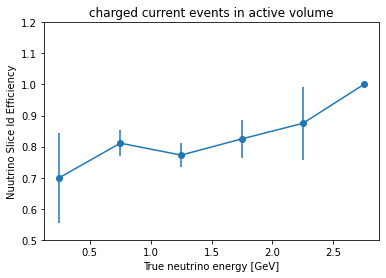

In [12]:
def Eff(df,var,query,acceptance,bin_edges,absval=False):
    bin_centers = 0.5*(bin_edges[1:]+bin_edges[:-1])
    bins = []
    bin_eff = []
    bin_err = []
    for i in range(len(bin_centers)):
        binmin = bin_edges[i]
        binmax = bin_edges[i+1]
        bincut = '%s > %f and %s < %f'%(var,binmin,var,binmax)
        if (absval == True):
            bincut = '(%s > %f and %s < %f) or (%s > -%f and %s < -%f)'%(var,binmin,var,binmax,var,binmax,var,binmin)
        if (acceptance != ''): bincut += ' and %s'%acceptance
        df_tmp =  df.query(bincut) # cut on bin range for desired var.
        df_sub = df_tmp.query(query) # apply constrain 
        if (df_tmp.shape[0] == 0): continue
        eff = df_sub.shape[0] / float( df_tmp.shape[0] )
        err = np.sqrt( eff*(1-eff)/df_tmp.shape[0] )
        bin_eff.append( eff )
        bin_err.append( err )
        bins.append(bin_centers[i])
    return np.array(bins),np.array(bin_eff),np.array(bin_err)

bin_edges = np.linspace(0,3,7)
centers,vals,errs = Eff(event,'nu_energy','pdg>0','is_cc==1 and inActiveVol==True',bin_edges)
plt.errorbar(centers,vals,yerr=errs,fmt='o-')
plt.xlabel('True neutrino energy [GeV]')
plt.ylabel('Nuutrino Slice Id Efficiency')
plt.title('charged current events in active volume')
plt.ylim(0.5,1.2)
plt.show()


For events where the correct slice is found, we can now check the accuracy of the neutrino vertex position reconstruction, both in cartesian coordinates and in wire units.

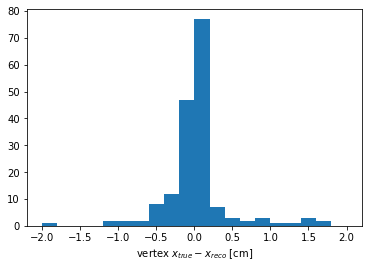

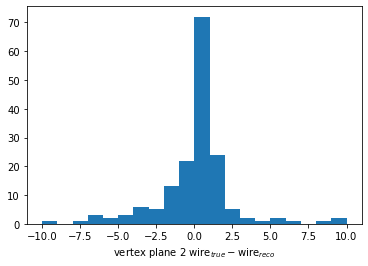

In [13]:
nuvtx = event.query('pdg>0 and is_cc==1 and inActiveVol==True')

plt.hist(nuvtx['nu_vtx_corr_0']-nuvtx['vtx_0'],bins=np.linspace(-2,2,21))
plt.xlabel(r'vertex $x_{true}-x_{reco}$ [cm]')
plt.show()

plt.hist(nuvtx['nu_vtx_wire_pos_2']-nuvtx['vtx_wire_pos_2'],bins=np.linspace(-10,10,21))
plt.xlabel(r'vertex plane 2 wire$_{true}-$wire$_{reco}$')
plt.show()

## Particle Completeness and Purity

We now want to study the performance at particle level. First we need to take the particle table (containing the true particle info) and run the labeling function. We then get the pandoraPfp table, which contains the pandora reconstructed particle information. We then merge these data frames, as well as the slice data frame used earlier, with the hit data frame.

In [14]:
particles = Table2DataFrame(f["particle_table"])
evtparts = particles.groupby(["run","sub","evt"])

#this may take a bit of time
labls = evtparts.apply(lambda x: panoptic_label(x)).reset_index().drop('level_3',axis=1)
labls

,run,sub,evt,g4_id,parent_id,type,start_process,end_process,momentum,semantic_label,instance_label
0,7419,0,1,2,0,2112,b'primary',b'neutronInelastic',0.678711,7,-1
1,7419,0,1,56,2,2112,b'neutronInelastic',b'nCapture',0.056113,7,-1
2,7419,0,1,3,0,2212,b'primary',b'protonInelastic',0.808312,3,0
3,7419,0,1,8,3,2112,b'protonInelastic',b'neutronInelastic',0.571445,7,-1
4,7419,0,1,483,8,2112,b'neutronInelastic',b'neutronInelastic',0.546223,7,-1
...,...,...,...,...,...,...,...,...,...,...,...
81612,7633,266,13321,3,2,11,b'hIoni',b'FastScintillation',0.000799,8,-1
81613,7633,266,13321,4,2,11,b'hIoni',b'FastScintillation',0.000796,8,-1
81614,7633,266,13321,5,2,11,b'hIoni',b'FastScintillation',0.000698,8,-1
81615,7633,266,13321,6,2,11,b'hIoni',b'FastScintillation',0.000652,8,-1


In [15]:
pfps = Table2DataFrame(f["pandoraPfp_table"])
print(pfps.columns)#fixme typo in tkrshr_score

Index(['run', 'sub', 'evt', 'vtx_0', 'vtx_1', 'vtx_2', 'vtx_wire_pos_0',
       'vtx_wire_pos_1', 'vtx_wire_pos_2', 'pdg', 'pfp_id', 'tkrshr_score',
       'vtx_wire_time'],
      dtype='object')


In [16]:
hits = hits.merge(slices[["run","sub","evt","slice_id","pdg"]], on=["run","sub","evt","slice_id"], how='left')
hits = hits.merge(labls, on=["run","sub","evt","g4_id"], how="left")
hits = hits.merge(pfps[["run","sub","evt","pfp_id","pdg","tkrshr_score"]], on=["run","sub","evt","pfp_id"], how='left', suffixes=['_slice','_pfp'])

We now want to count the number of hits per true particle isntance and per reconstructed particle (pfp).

In [17]:
pfphits = hits.groupby(["run","sub","evt","pdg_slice","slice_id","pfp_id","tkrshr_score"]).size().reset_index().rename(columns={0:'pfphits'})
insthits = hits.groupby(["run","sub","evt","semantic_label","instance_label"]).size().reset_index().rename(columns={0:'insthits'})
pfpinsthits = hits.groupby(["run","sub","evt","pdg_slice","slice_id","pfp_id","semantic_label","instance_label"]).size().reset_index().rename(columns={0:'pfpinsthits'})

pfpinsthits = pfpinsthits.merge(pfphits, on=["run","sub","evt","slice_id","pfp_id","pdg_slice"], how='left')
pfpinsthits = pfpinsthits.merge(insthits, on=["run","sub","evt","semantic_label","instance_label"], how='left')
pfpinsthits.fillna(-1,inplace=True)

pfpinsthits

,run,sub,evt,pdg_slice,slice_id,pfp_id,semantic_label,instance_label,pfpinsthits,tkrshr_score,pfphits,insthits
0,7419,0,1,13.0,0,-1,7.0,-1.0,8,-1.000000,-1.0,111
1,7419,0,1,13.0,1,-1,7.0,-1.0,3,-1.000000,-1.0,111
2,7419,0,1,13.0,4,-1,7.0,-1.0,8,-1.000000,-1.0,111
3,7419,0,1,13.0,5,-1,7.0,-1.0,92,-1.000000,-1.0,111
4,7419,0,44,13.0,1,-1,7.0,-1.0,2,-1.000000,-1.0,15
...,...,...,...,...,...,...,...,...,...,...,...,...
6008,7633,266,13321,14.0,5,-1,7.0,-1.0,1,-1.000000,-1.0,1
6009,7633,266,13321,14.0,5,5,1.0,0.0,65,0.641730,831.0,252
6010,7633,266,13321,14.0,5,14,1.0,0.0,184,0.950765,184.0,252
6011,7633,266,13321,14.0,5,15,1.0,0.0,1,0.926435,147.0,252


We can select which category of particles we want to study, based on the label enum in standard_labels.py. Then we select entries in the data frame for instances of this category and pfps in the neutrino slice.

In [18]:
selcategory = 1 #1:muon, 4:shower, see label standard_labels.py
print('notebook will produce performance for instances of label:',label(selcategory).name)

notebook will produce performance for instances of label: muon


In [19]:
selhits = pfpinsthits.query('(pdg_slice==12 or pdg_slice==14) and semantic_label==%i'%selcategory)
selhits = selhits.sort_values(by=['pfpinsthits'], ascending=False)
selhits.sort_values(by=["run","sub","evt"],inplace=True)
selhits.drop_duplicates(["run","sub","evt","instance_label"], inplace=True)
selhits

,run,sub,evt,pdg_slice,slice_id,pfp_id,semantic_label,instance_label,pfpinsthits,tkrshr_score,pfphits,insthits
16,7419,0,44,14.0,0,0,1.0,0.0,2126,1.000000,2193.0,2134
42,7419,3,164,14.0,14,16,1.0,0.0,170,0.719929,218.0,170
46,7419,3,164,14.0,14,26,1.0,5.0,1,0.177217,39.0,2
82,7420,3,176,14.0,0,0,1.0,0.0,1932,1.000000,1965.0,1951
88,7420,5,276,14.0,2,2,1.0,0.0,1550,1.000000,1592.0,1553
...,...,...,...,...,...,...,...,...,...,...,...,...
5937,7633,229,11465,14.0,3,3,1.0,0.0,1004,1.000000,1078.0,1022
5959,7633,262,13103,14.0,7,7,1.0,0.0,694,0.999740,710.0,695
5965,7633,264,13215,12.0,11,11,1.0,0.0,251,0.413849,587.0,251
5999,7633,264,13226,14.0,12,19,1.0,0.0,120,0.855182,128.0,132


At this point we can plot the purity and efficiency for identifying instances of this category.

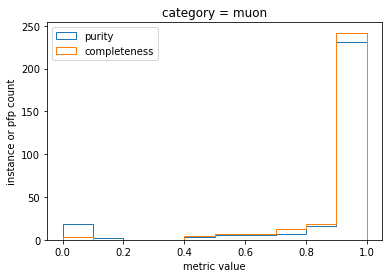

In [20]:
purity = selhits['pfpinsthits']/selhits['pfphits']
completeness = selhits['pfpinsthits']/selhits['insthits']
plt.hist(purity,histtype='step',label='purity',bins=np.linspace(0,1,11))
plt.hist(completeness,histtype='step',label='completeness',bins=np.linspace(0,1,11))
plt.legend(loc=2)
plt.xlabel('metric value')
plt.ylabel('instance or pfp count')
plt.title('category = %s'%label(selcategory).name)
plt.show()

We can also check the value of the track-shower discriminator from Pandora for particles of this category. Values close to -1 are more shower-like, while those close to 1 are more track-like. We expect photons and electrons to be shower-like, while muons, protons, and charged pions to be track-like.

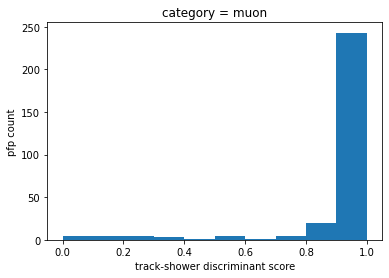

In [21]:
plt.hist(selhits['tkrshr_score'],bins=np.linspace(0,1,11))
plt.xlabel('track-shower discriminant score')
plt.ylabel('pfp count')
plt.title('category = %s'%label(selcategory).name)
plt.show()